# Essentia Intro

First we need to import the Essentia module.

In [1]:
import essentia

# as there are 2 operating modes in essentia which have the same algorithms,
# these latter are dispatched into 2 submodules:

import essentia.standard
import essentia.streaming

# let's have a look at what is in there

#print dir(essentia.standard)

# you can also do it by using autocompletion in IPython, typing "essentia.standard." and pressing Tab

%matplotlib inline

Before you can use algorithms in Essentia, you first need to instantiate (create) them. When doing so, you can give them parameters which they may need to work properly, such as the filename of the audio file in the case of an audio loader.
Once you have instantiated an algorithm, nothing has happened yet, but your algorithm is ready to be used and works like a function, that is, you have to call it to make stuff happen.

In [2]:
# Essentia has a selection of audio loaders:
#
#  - AudioLoader: the basic one, returns the audio samples, sampling rate and number of channels
#  - MonoLoader: which returns audio, down-mixed and resampled to a given sampling rate
#  - EasyLoader: a MonoLoader which can optionally trim start/end slices and rescale according
#                to a ReplayGain value
#  - EqloudLoader: an EasyLoader that applies an equal-loudness filtering on the audio
#

# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename = 'NuvoleBianche.mp3')

# and then we actually perform the loading:
audio = loader()

print(audio[40*44100:41*44100])
# by default, the MonoLoader will output audio with 44100Hz samplerate

[-0.00750732 -0.00717163 -0.00694275 ..., -0.00184631 -0.00175476
 -0.00169373]


To make sure that this actually worked, let’s plot a 1-second slice of audio, from t = 1sec to t = 2sec:

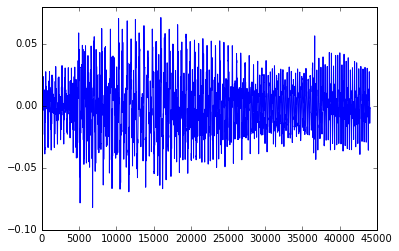

In [3]:
# pylab contains the plot() function, as well as figure, etc... (same names as Matlab)
from pylab import plot, show, figure

plot(audio[40*44100:41*44100])
#show() # unnecessary if you use matplotlib inline

Let's compute the [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (commonly used as features in speech recognition) for the frames in the audio. 

We will need the following algorithms: Windowing, Spectrum, MFCC 

In [4]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
mfcc = MFCC()

# let's have a look at the inline help:
help(MFCC)


# you can also see it by typing "MFCC?" in IPython

Help on class Algo in module essentia.standard:

class Algo(Algorithm)
 |  MFCC
 |  
 |  
 |  Inputs:
 |  
 |    [vector_real] spectrum - the audio spectrum
 |  
 |  
 |  Outputs:
 |  
 |    [vector_real] bands - the energies in mel bands
 |    [vector_real] mfcc - the mel frequency cepstrum coefficients
 |  
 |  
 |  Parameters:
 |  
 |    highFrequencyBound:
 |      real ∈ (0,inf) (default = 11000)
 |      the upper bound of the frequency range [Hz]
 |  
 |    inputSize:
 |      integer ∈ (1,inf) (default = 1025)
 |      the size of input spectrum
 |  
 |    lowFrequencyBound:
 |      real ∈ [0,inf) (default = 0)
 |      the lower bound of the frequency range [Hz]
 |  
 |    numberBands:
 |      integer ∈ [1,inf) (default = 40)
 |      the number of mel-bands in the filter
 |  
 |    numberCoefficients:
 |      integer ∈ [1,inf) (default = 13)
 |      the number of output mel coefficients
 |  
 |    sampleRate:
 |      real ∈ (0,inf) (default = 44100)
 |      the sampling rate of the

In [5]:
help(essentia.array)

Help on function array in module essentia.common:

array(object, **kwargs)
    # force the array objects to be of type float32



And remember that once algorithms have been instantiated, they work like normal functions:

[-0.0055542  -0.00627136 -0.00694275 ..., -0.01623535 -0.01615906
 -0.01618958]
(1024,)
float32


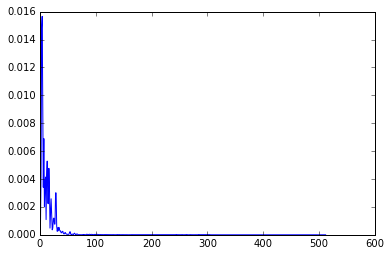

In [6]:
frame = audio[5*44100 : 5*44100 + 1024]
print(frame)
print(frame.shape)
print(frame.dtype)
spec = spectrum(w(frame))

plot(spec)

We can create frames with the 'FrameGenerator' algorithm. Since Essentia was designed for audio processing, a lot of algorithms related to audio processing are readily available. See the [algorithm overview](http://essentia.upf.edu/documentation/algorithms_overview.html) or the [complete reference](http://essentia.upf.edu/documentation/algorithms_reference.html) for more details.

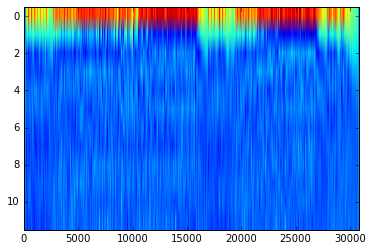

In [7]:
import matplotlib.pyplot as plt
mfccs = []

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)

# transpose to have it in a better shape
# we need to convert the list to an essentia.array first (== numpy.array of floats)
mfccs = essentia.array(mfccs).T

# and plot
plt.imshow(mfccs[1:,:], aspect = 'auto')

# We ignored the first MFCC coefficient to disregard the power of the signal and only plot its spectral shape

### Introducing the 'Pool'
A Pool is a container similar to a C++ map or Python dict which can contain any type of values (easy in Python, not as much in C++...). Values are stored in there using a name which represent the full path to these values; dot (‘.’) characters are used as separators. You can think of it as a directory tree, or as namespace(s) + local name.

Examples of valid names are: "bpm", "lowlevel.mfcc", "highlevel.genre.rock.probability", etc...

Re-computing the steps above using a pool:

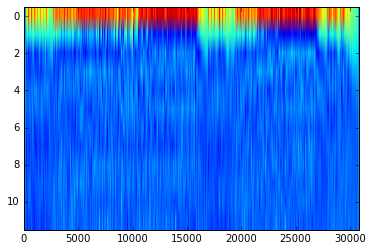

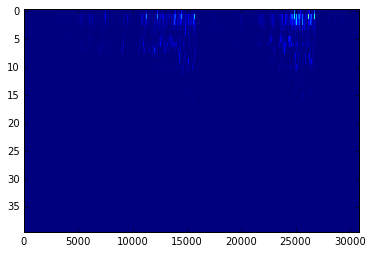

In [8]:
pool = essentia.Pool()

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)
    pool.add('lowlevel.mfcc_bands', mfcc_bands)

plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto')

figure()
plt.imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', interpolation = 'nearest')

## Aggregation and File Output
In order to store the results of our computations in e.g. the [YAML](http://yaml.org) or the [JSON](https://en.wikipedia.org/wiki/JSON) format one can use the 'YamlOutput' algorithm.

In [9]:
output = YamlOutput(filename = 'mfcc_json.sig',format = 'json') # use "format = 'json'" for JSON output
output(pool)

# or as a one-liner:
YamlOutput(filename = 'mfcc.sig')(pool)

As this writes MFCCs for all the frames the files are quite big (28MB for the Nuvole Bianche example).

Now let’s assume we do not want all the frames but only the mean and variance of those frames. We can do this using the PoolAggregator algorithm and use it on the pool to get a new pool with the aggregated descriptors:

In [10]:
# compute mean and variance of the frames
aggrPool = PoolAggregator(defaultStats = [ 'mean', 'var' ])(pool)

print 'Original pool descriptor names:'
print pool.descriptorNames()
print
print 'Aggregated pool descriptor names:'
print aggrPool.descriptorNames()

# and ouput those results in a file
YamlOutput(filename = 'mfccaggr.sig')(aggrPool)

Original pool descriptor names:
['lowlevel.mfcc', 'lowlevel.mfcc_bands']

Aggregated pool descriptor names:
['lowlevel.mfcc.mean', 'lowlevel.mfcc.var', 'lowlevel.mfcc_bands.mean', 'lowlevel.mfcc_bands.var']
